# Oppgave: Gjenkjenning av håndskrevne tall
Vi har et bildesett av ca 60000 håndskrevne tall. Vi vil bruke disse til å kjenne igjen andre andre håndskrevne tall.
Alle bildene er 28x28 piksler.

## Litt om bilder på datamaskin
Bildene i denne oppgaven representeres som en tabell av heltall mellom 0 og 255, der 0 er hvit og 255 er svart. Verdiene 1-254 er forskjellige gråtoner.

Hver av de 28x28 (784) pikslene skal vi bruke som forklaringsvariable.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn


from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import itertools

from scipy.ndimage import imread

# Legger til mappen over i path, slik at vi kan importere useful_tools
import sys
import os
sys.path.append(os.path.split(os.path.abspath(os.getcwd()))[0])

from useful_tools import ModelTester

# Forhindrer rutenett når vi viser fram bilder
seaborn.set_style("whitegrid", {'axes.grid' : False})

## Laste inn data
Vi leser inn dataene. Lag en dataframe med features (pikslene i bildet) og en med labels (tallet det er bilde av)

**OBS:** Det er veldig viktig at du kaller features-variabelen for `features` og tilsvarende for `labels`, for at neste celle skal fungere.

In [8]:
data = pd.read_csv("../../datasets/mnist/mnist_train.csv", header=-1)

data.columns = ['label'] + list(data.columns)[1:]

features = data.drop(['label'], axis=1)
labels = data[['label']]

For å sjekke at alt er i orden kan vi vise frem det første bildet

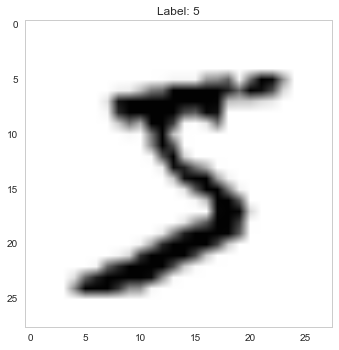

In [9]:
first_image = np.reshape(features.values[0],(28,28))
plt.imshow(first_image)
plt.title('Label: {}'.format(labels.values[0][0]))
plt.show()

## Del opp i trening- og testdata
Prediksjon med KNN tar lang tid hvis man har mye data. Dette skyldes at avstandene til punktene i treningssettet må regnes ut for alle nye punkter. Derfor kan det være lurt å holde oss til f.eks. de første 10000 bildene i datasettet.

Du kan hente ut de første 10000 elementene ved å si `features[:10000]` og `labels[:10000]` i kallet til `train_test_split`.

Det er også lurt å lage en `ModelTester` med treningsdataene.

In [10]:
# Din kode start
features_train, features_test, labels_train, labels_test = train_test_split(features[:10000], labels[:10000], test_size=0.33)
tester = ModelTester(features_test, labels_test)
# Din kode slutt

## Tren en K nærmeste nabo-klassifikator

Lag en `KNeighborsClassifier`, og tilpass den til treningsdataene. Siden `fit` i dette tilfellet vil ha en array, og ikke en kolonne, bør du bruke `labels_train.values.ravel()` i `fit`.

In [11]:
# Din kode start
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(features_train, labels_train.values.ravel())
# Din kode slutt

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

### Avstand mellom bilder
Når vi snakker om avstanden mellom to bilder (bilde A og bilde B), regner vi ut avstanden ved å ta hver av pikslene i A bildet og trekker fra verdien i de korresponderende pikslene til B. Deretter kvadrerer vi, slik at alle verdiene blir positive. Deretter summerer vi dem (og tar kvadratroten).

Du kan tenke på det som å legge de to bildene oppå hverandre, og summe de pikslene der det *ikke* er overlapp.

## Hva ble nøyaktigheten?

Bruk modellen og prediker på testdata. Bruk `ModelTester` til å plotte forvirringsmatrisen.

**OBS:** Kall predikatene for `predictions` slik at vi kan kjøre koden nedenfor uten for mye trøbbel

### Forvirringsmatrisen
Du har kanskje ikke sett forvirringsmatrisen tidligere. Forvirringsmatrisen er en tabell som forteller hvor godt klassifikatoren gjorde det for de forskjellige klassene.

På y-aksen har du sann klasse, og på x-aksen den predikerte klassen. I hver rute `(x, y)` ser du altså hvor mange fra klasse `y` som ble klassifisert til `x`. Dette betyr at vi i en ideel verden kun ville hatt tall større enn null på diagonalen fra øverste høyre hjørne til nederste venstre. Hvis alle tallene utenfor denne diagonalen er null, betyr det at vi ikke har klassifisert noen av punktene feil.

Confusion matrix, without normalization


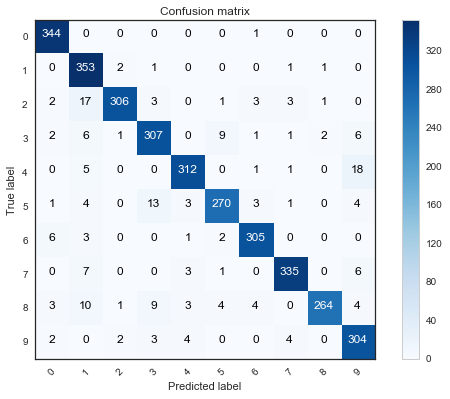

Accuracy:  93.9393939394 %


In [12]:
# Din kode start
predictions  = clf.predict(features_test)
cnf_mat, accuracy = tester.test_classifier(clf, list(map(str, range(10))))
# Din kode slutt

Muligheten er stor for at du fikk høy nøyaktighet, men det er selvsagt noen bilder som ble klassifisert feil. For å få en bedre innsikt i klassifikatoren, kan vi vise frem de bildene som ble feilklassifiserte. Vi ser på noen av dem. Ved siden av plotter vi de fem nærmeste naboene.

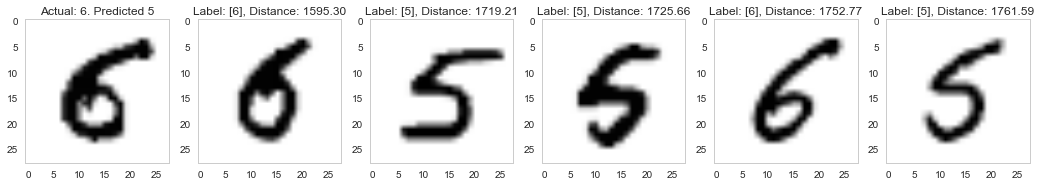

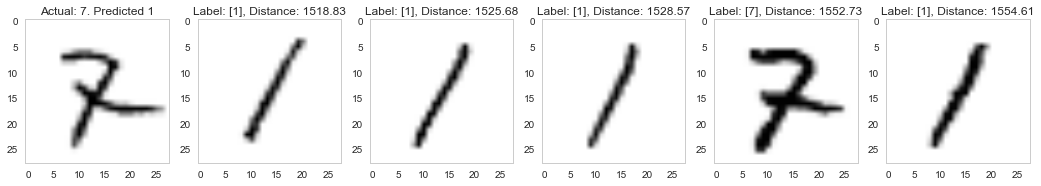

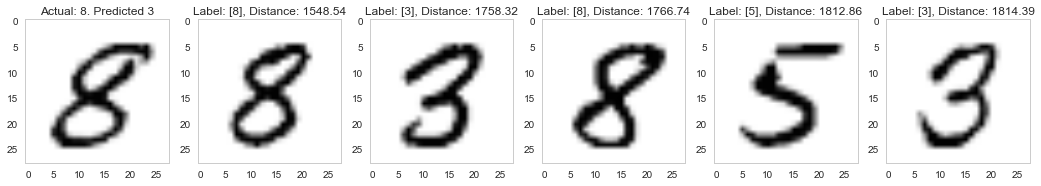

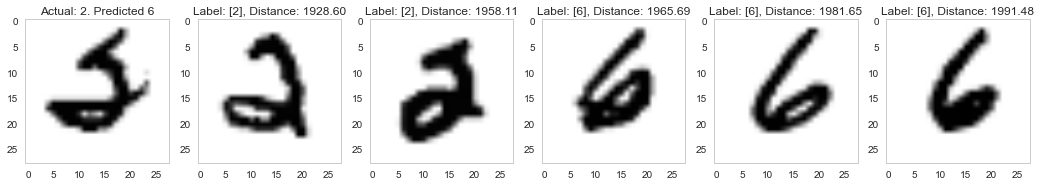

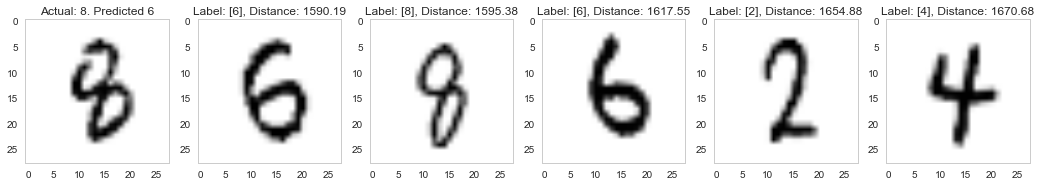

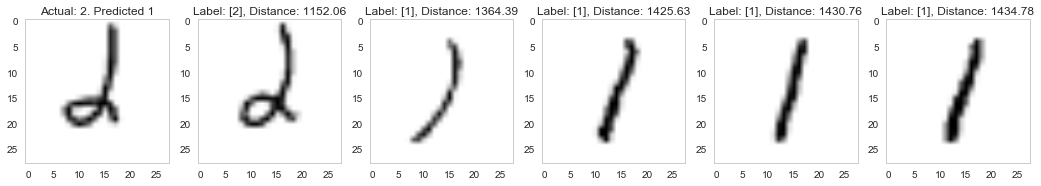

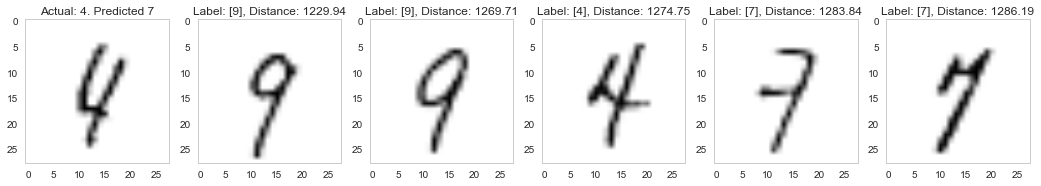

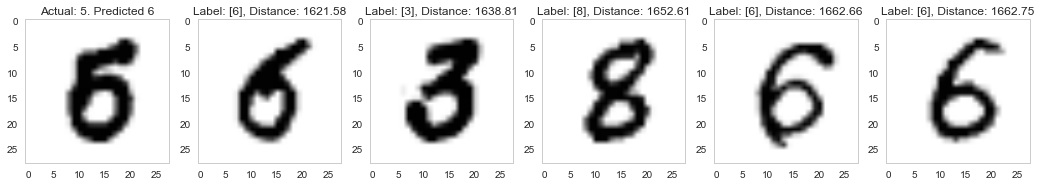

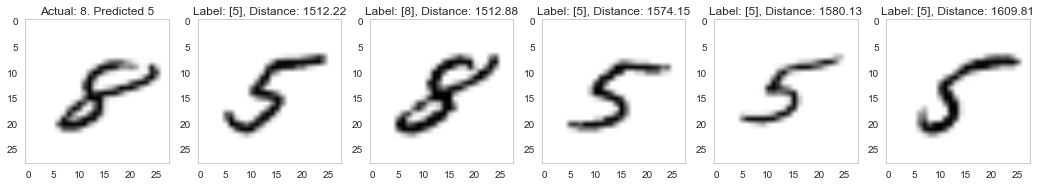

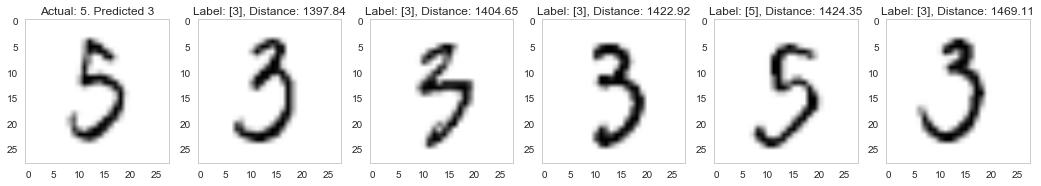

In [13]:
wrong_class = predictions!=labels_test.values.ravel()
wrong_images = features_test[wrong_class]

for i, row in enumerate(itertools.islice(wrong_images.iterrows(), 10)):
    id_num, im_row = row
    im = im_row.values.reshape(28, 28)
    dist, nearest = clf.kneighbors(im_row.values.reshape(1, -1), n_neighbors=5)
    plt.figure(figsize=(18, 3))
    
    plt.subplot(1, 6, 1)
    plt.imshow(im)
    plt.title('Actual: %d. Predicted %d' % (labels_test.loc[id_num], predictions[wrong_class][i]))

    
    j = 2
    for i, d in zip(nearest[0], dist[0]):
        plt.subplot(1, 6, j)
        plt.imshow(features_train.iloc[i].values.reshape(28, 28))
        plt.title('Label: {}, Distance: {:.2f}'.format(labels_train.iloc[i].values, d))
        j += 1
    plt.show()


**Oppgave 1:** Ta for deg noen av de feilklassifiserte bildene ovenfor, og gi en mulig grun for hvorfor KNN har endt opp med nettopp det resultatet.

**Oppgave 2:** Alle bildene i MNIST-datasettet er slik at alle sifferne er omtrent like store og plassert omrent midt i bildet. Forklar hvorfor dette er lurt å gjøre. Særlig med tanke på å bruke K nærmeste nabo til å klassifisere et bilde.

**Oppgave 3:** Lag noen egne bilder i f.eks. Microsoft Paint eller GIMP. Ta diskusjonen i forrige oppgave i betraktning når du tegner. Prøv ut forskjellige plasseringer og rotasjoner av sifrene, og kanskje også tykkelsen på streken. **OBS:  Husk at bildet må være 28x28**

Hvilke tall er enkle å klassfisere rett? Hvilke er vanskelige? Hvorfor?

For å lese inn bildene dine i denne oppgaven kan du bruke funksjonen `read_image`, som er definert nedenfor. Den tar inn filnavnet, leser bildet inn som gråtoner og returnerer en 1 x `antall piksler`-array der hvert element korresponderer til en piksel i bildet. Dette gjøres for at vi skal kunne sende bildet til `predict`-metoden i modellen. Dersom bildet ikke er 28x28 piksler, vil funksjonen printe en advarsel.

Dersom du vil vise bildet må du derfor bruke `reshape`-metoden. For eksempel kan du gjøre slik:
```python
im = read_image('../bilde.png')
plt.imshow(im.reshape(28, 28))
plt.show()
```

Hvis du synes dette er mye på en gang, kan du lage et bilde for alle tallene fra 0-9 og lagre de som `0.png`, `1.png` osv i mappen `../../datasets/mnist/new/0.png`. Da kan du bruke koden i den siste cellen, som vil lese inn alle disse bildene for deg, klassifisere og vise de sammen med de nærmeste naboene, slik som ovenfor. Merk at koden i den siste cellen er kommentert ut. Du må fjerne alle `#` først.

In [14]:
def read_image(filename):
    im = 255-imread(filename, flatten=True)
    if im.shape != (28, 28):
        print('Advarsel: {} er ikke 28 x 28 piksler!'.format(filename))
    return im.reshape(1, -1)

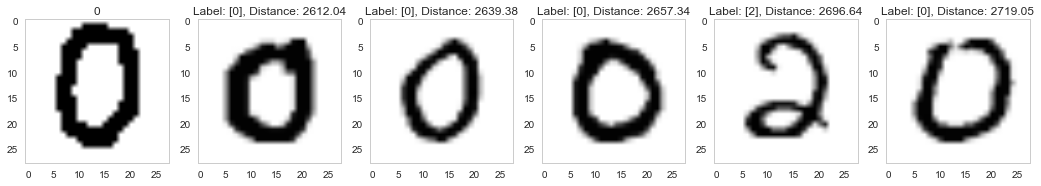

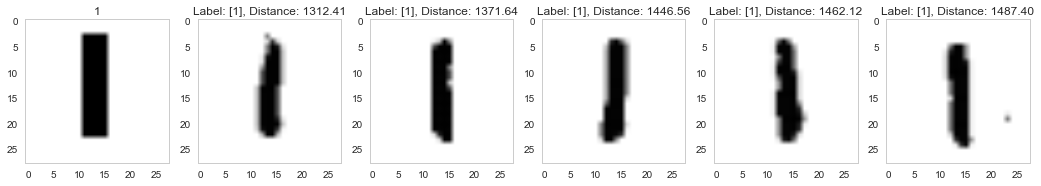

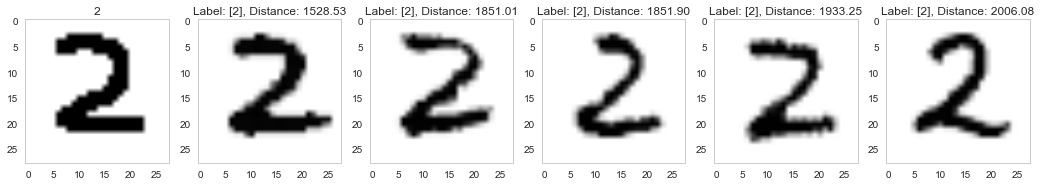

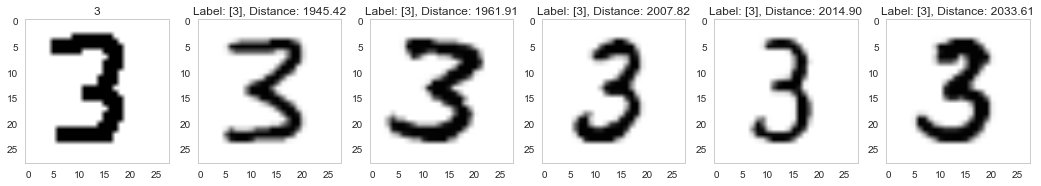

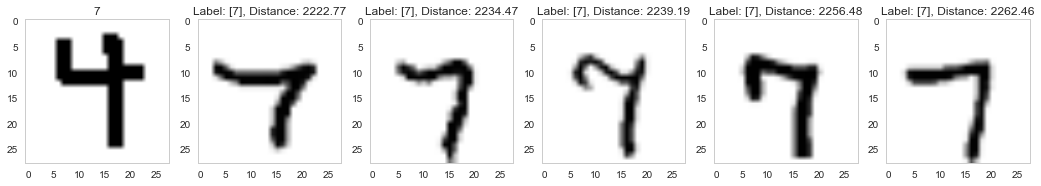

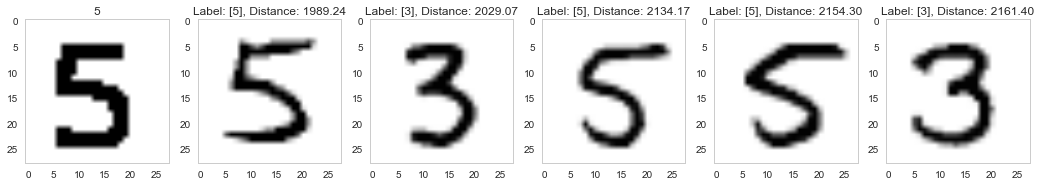

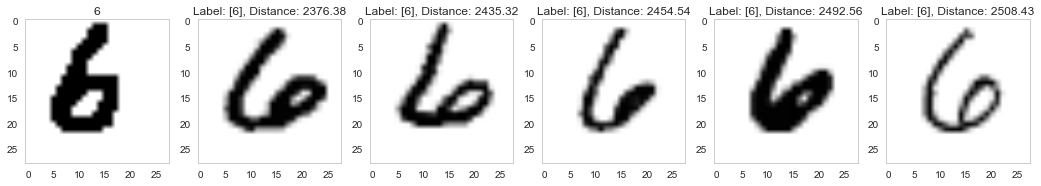

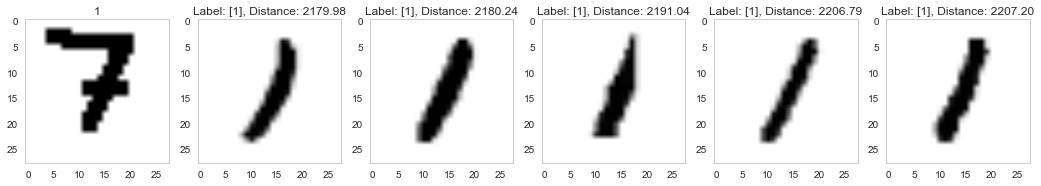

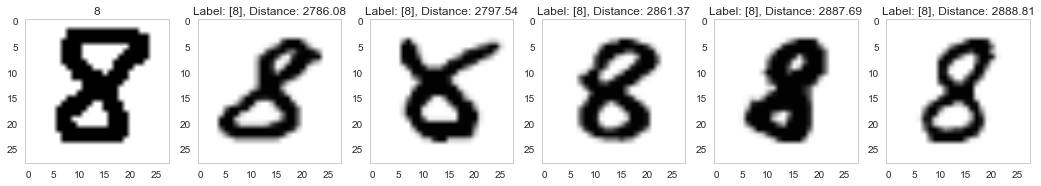

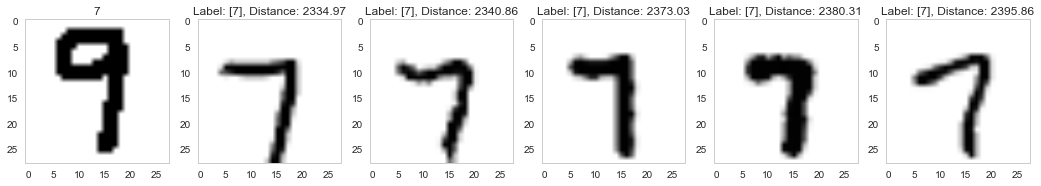

In [15]:
for i in range(10):
    filename = '../../datasets/mnist/new/{}.png'.format(i)
    
    try:
        im = read_image(filename)
    except FileNotFoundError:
        print('Fant ikke filen. Hopper over')
        continue
    
    dist, nearest = clf.kneighbors(im, n_neighbors=5)
    
    plt.figure(figsize=(18, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(im.reshape(28, 28))
    pred = clf.predict(im)  
    plt.title('{}'.format(pred[0]))
    
    j = 2
    for i, d in zip(nearest[0], dist[0]):
        plt.subplot(1, 6, j)
        plt.imshow(features_train.iloc[i].values.reshape(28, 28))
        plt.title('Label: {}, Distance: {:.2f}'.format(labels_train.iloc[i].values, d))
        j += 1

plt.show()